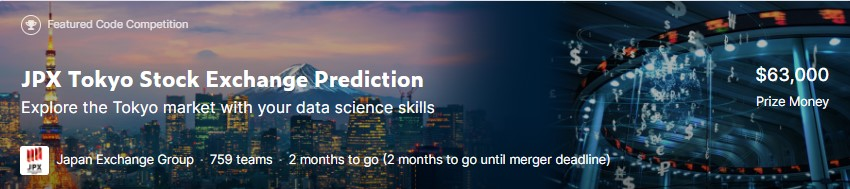


This competition will compare your models against real future returns after the training phase is complete. The competition will involve building portfolios from the stocks eligible for predictions (around 2,000 stocks). Specifically, each participant ranks the stocks from highest to lowest expected returns and is evaluated on the difference in returns between the top and bottom 200 stocks. You'll have access to financial data from the Japanese market, such as stock information and historical stock prices to train and test your model.

All winning models will be made public so that other participants can learn from the outstanding models. Excellent models also may increase the interest in the market among retail investors, including those who want to practice quantitative trading. At the same time, you'll gain your own insights into programmatic investment methods and portfolio analysis―and you may even discover you have an affinity for the Japanese market.

In [ ]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import jpx_tokyo_market_prediction


from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

In [ ]:
!pip install optuna

In [ ]:
train_df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv', parse_dates=True)
valid_df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv', parse_dates=True)
test_df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv', parse_dates=True)

In [ ]:
### Loading Stock Prices
### Not Abused 
### from : JPX simple overfitting model - LB≃3






# path = "../input/jpx-tokyo-stock-exchange-prediction/"

# df_prices = pd.read_csv(f"{path}train_files/stock_prices.csv")
# df_prices = df_prices[~df_prices["Target"].isnull()]
# prices = pd.read_csv(f"{path}supplemental_files/stock_prices.csv")
# df_prices = pd.concat([df_prices, prices])
# df_prices = df_prices[df_prices.Date>="2021-10-01"]
# df_prices.info(show_counts=True)

In [ ]:
print(train_df.shape )
print(valid_df.shape )


print("train_df Null Check : {}".format(train_df.isnull().sum()))
print('----------------------------------------------------------')
print("valid_df Null Check : {}".format(valid_df.isnull().sum()))

In [ ]:
prices = valid_df

del train_df, valid_df

In [ ]:
prices = prices.drop(["ExpectedDividend"],axis=1)

<div style="background-color:rgba(0, 255, 255, 0.6);border-radius:5px;display:fill;">
    <h1><center>Function definition</center></h1>
</div>

In [ ]:
average = pd.DataFrame(prices.groupby("SecuritiesCode").Target.mean())
def get_avg(_id_):
    return average.loc[_id_]



def getadvance(x):
    ret = 0
    if x > 0:
        ret = 1
    return(ret)

def get_month(dt):
    x = dt.strftime("%m")
    return(x)


def cat_col(data) :
    data['SecuritiesCode'] = data['SecuritiesCode'].astype('category')
    data['SupervisionFlag'] = data['SupervisionFlag'].astype('category')
    data['advance'] = data['advance'].astype('category')
    data['AdjustmentFactor'] = data['AdjustmentFactor'].astype('category')
    data['Month'] = data['Month'].astype('category')
    return data 

In [ ]:
prices["Avg"] = prices["SecuritiesCode"].apply(get_avg)


prices['pClose'] = prices['Close'].shift(-1)
prices['delta'] = prices['Close'] - prices['pClose']
prices['advance'] = list(map(getadvance, prices['delta']))
prices['Date'] = pd.to_datetime(prices['Date'], format = "%Y-%m-%d")
prices['Month'] =  list(map(get_month, prices['Date']))

prices = cat_col(prices)

In [ ]:
prices.isnull().sum()

In [ ]:
prices.columns

In [ ]:
features = ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'SupervisionFlag', 'Avg',
       'pClose', 'delta', 'advance', 'Month']

In [ ]:
prices.isnull().sum()

In [ ]:
# data segmentation
prices['Date'] = prices['Date'].dt.strftime("%Y%m%d").astype(int)

X = prices[features]
y = prices['Target']
codes = X.SecuritiesCode.unique()

<div style="background-color:rgba(0, 255, 255, 0.6);border-radius:5px;display:fill;">
    <h1><center>Optuna + bestparameter searching</center></h1>
</div>

In [ ]:
def objectives(trial):
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 300, 8000),
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
            'max_bin': trial.suggest_int('max_bin', 2, 100),
            'learning_rate': trial.suggest_uniform('learning_rate',0, 1),
    }

    model = LGBMRegressor(**params)
    model.fit(X,y)
    score = model.score(X,y)
    return score

In [ ]:
import optuna

studyLGBM = optuna.create_study(direction='maximize',sampler=optuna.samplers.RandomSampler(seed=0))
studyLGBM.optimize(objectives, n_trials=10)

trial = studyLGBM.best_trial
params_best = dict(trial.params.items())
params_best['random_seed'] = 0
    
model = LGBMRegressor(**params_best)#

In [ ]:
print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

In [ ]:
#Parameter importance Visual
optuna.visualization.plot_param_importances(studyLGBM)

<div style="background-color:rgba(0, 255, 255, 0.6);border-radius:5px;display:fill;">
    <h1><center>Model Drive</center></h1>
</div>

In [ ]:
model.fit(X,y)
model.score(X,y)

<div style="background-color:rgba(0, 255, 255, 0.6);border-radius:5px;display:fill;">
    <h1><center>submission</center></h1>
</div>

In [ ]:
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    ds=[prices, options, financials, trades, secondary_prices, sample_prediction]
        
    prices["Avg"] = sample_prediction["SecuritiesCode"].apply(get_avg)
    
    prices['pClose'] = prices['Close'].shift(-1)
    prices['delta'] = prices['Close'] - prices['pClose']
    prices['advance'] = list(map(getadvance, prices['delta']))
    prices['Date'] = pd.to_datetime(prices['Date'], format = "%Y-%m-%d")
    prices['Month'] =  list(map(get_month, prices['Date']))
    

    prices = cat_col(prices)
    prices['Date'] = prices['Date'].dt.strftime("%Y%m%d").astype(int)
    print('-------------------------------prices------------------------------')
    print(prices)
    print('------------------------------------------------------------------------------')    
    
    prices = prices.drop(['RowId','ExpectedDividend'],axis=1)

    sample_prediction["Prediction"] = model.predict(prices)
    print('-------sample_prediction--------')
    print(sample_prediction)
    sample_prediction = sample_prediction.sort_values(by = "Prediction", ascending=False)
    sample_prediction.Rank = np.arange(0,2000)
    sample_prediction = sample_prediction.sort_values(by = "SecuritiesCode", ascending=True)
    sample_prediction.drop(["Prediction"],axis=1)
    submission = sample_prediction[["Date","SecuritiesCode","Rank"]]
    print('-------------------------------submission------------------------------')
    print(submission)
    print('------------------------------------------------------------------------------')
    env.predict(submission)